
--- KDE uniformity check (20 random points) ---
       Point (x,y) │  Estimate │     Error
----------------------------------------------
[0.473 0.157] │    2.3049 │   -0.0045
[0.911 0.047] │    2.3039 │   -0.0055
[0.685 0.406] │    2.3004 │   -0.0090
[0.919 0.052] │    2.3030 │   -0.0064
[0.47  0.121] │    2.3118 │    0.0024
[0.79  0.208] │    2.3091 │   -0.0003
[0.679 0.527] │    1.9942 │   -0.3153
[0.488 0.344] │    2.3024 │   -0.0070
[0.436 0.507] │    2.2979 │   -0.0115
[0.299 0.223] │    2.3025 │   -0.0069
[0.475 0.589] │    2.3077 │   -0.0017
[0.221 0.12 ] │    2.3091 │   -0.0003
[0.68  0.134] │    2.3034 │   -0.0060
[0.523 0.483] │    2.3233 │    0.0139
[0.348 0.518] │    2.3042 │   -0.0052
[0.42  0.678] │    2.2210 │   -0.0884
[0.348 0.112] │    2.3008 │   -0.0086
[0.151 0.202] │    2.2820 │   -0.0274
[0.824 0.231] │    2.3028 │   -0.0066
[0.378 0.395] │    2.3313 │    0.0219
----------------------------------------------
Mean absolute error = 0.0274


--- Laplacian table ---

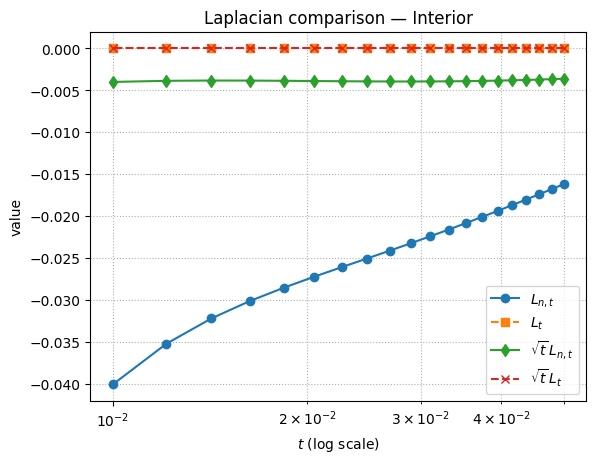

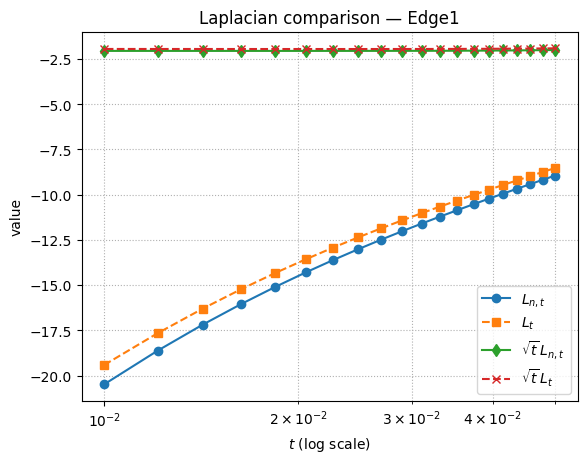

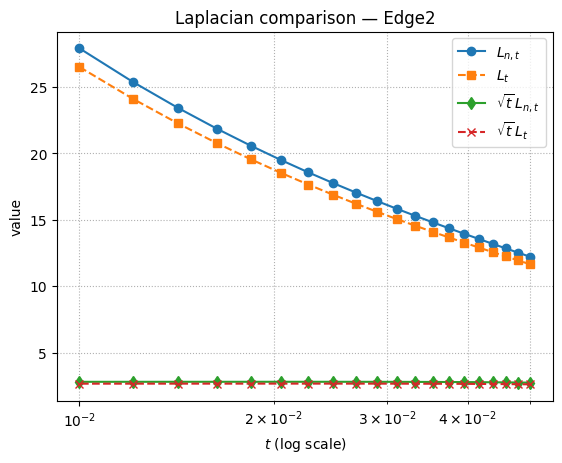

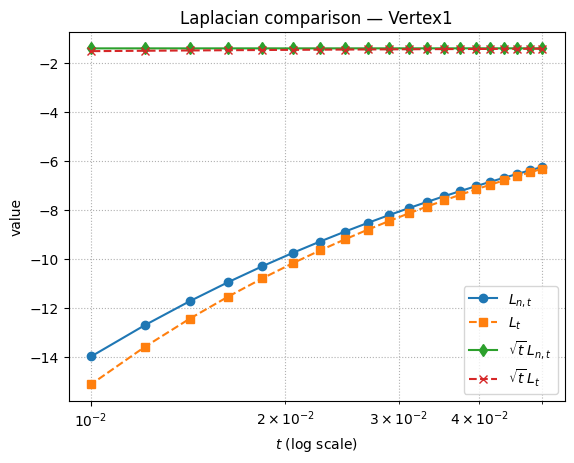

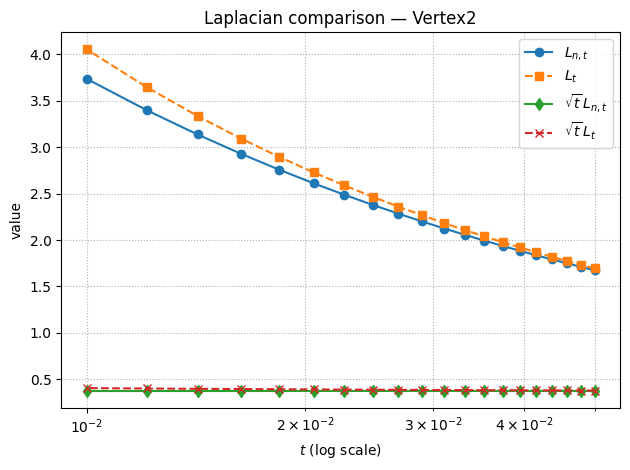

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helpers
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3) / 2.0])

def triangle_area(P, Q, R):
    return 0.5 * abs((Q[0]-P[0])*(R[1]-P[1]) - (R[0]-P[0])*(Q[1]-P[1]))

AREA = triangle_area(A, B, C)  # √3/4

def uniform_sample_triangle(P, Q, R, n):
    """Draw n iid uniform points in triangle via barycentric reflection."""
    u, v = np.random.rand(n), np.random.rand(n)
    mask = (u + v) > 1.0
    u[mask], v[mask] = 1-u[mask], 1-v[mask]
    w = 1 - u - v
    return (w[:, None]*P + u[:, None]*Q + v[:, None]*R)

# -------------------------------------------------------------------- #
# 1 · KDE uniformity check
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    kde   = gaussian_kde(samples.T)                # Scott’s rule
    check = uniform_sample_triangle(A, B, C, m_check)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    err   = est - true

    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y)':>18} │ {'Estimate':>9} │ {'Error':>9}")
    print("-"*46)
    for p, e, d in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {d:9.4f}")
    print("-"*46)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")



# -------------------------------------------------------------------- #
# 2 · Belkin Laplacians (correct normalizations)
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    """
    Discrete (Monte Carlo) Laplacian:
      L_{n,t} f(x) = 2/(n*t) ∑_j exp(-||x-X_j||^2/t) [f(x)-f(X_j)]
    """
    sq = np.sum((samples - x)**2, axis=1)
    K  = np.exp(-sq / t)
    return (1.0 / (len(samples) * t**2)) * np.sum(K * (f_x - f_samples))

def continuous_laplacian_quad(x, f_x, t, m=60):
    """
    Continuous Laplacian by Riemann quadrature:
      L_t f(x) = 2/(t*Area) ∫_triangle exp(-||x-y||^2/t)[f(x)-f(y)] dy
    Approximated on an (m+1)(m+2)/2 barycentric grid.
    """
    # build barycentric grid
    grid, f_grid = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w    = 1 - u - v
            y    = w*A + u*B + v*C
            grid.append(y)
            f_grid.append(y[0] + y[1])
    grid, f_grid = np.array(grid), np.array(f_grid)

    weight = AREA / len(grid)
    sq     = np.sum((grid - x)**2, axis=1)
    K      = np.exp(-sq / t)
    return (1.0 / (t**2 * AREA)) * np.sum(K * (f_x - f_grid) * weight)

# -------------------------------------------------------------------- #
# 3 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    # 3·1  Sample & f-values
    n_samples = 10_000_000
    samples   = uniform_sample_triangle(A, B, C, n_samples)
    f_samp    = samples[:,0] + samples[:,1]

    # 3·2  KDE uniformity
    kde_uniformity(samples)

    # define interior evaluation point (centroid)
    x = (A + B + C) / 3

    # 3·4  Full table & plots
    t_values = np.linspace(0.05, 0.01, 20)

    eval_pts = {
        "Interior": x,
        "Edge1"   : (A+B)/2,
        "Edge2"   : (B+C)/2,
        "Vertex1" : A,
        "Vertex2" : B
    }

    rows = []
    for t in t_values:
        row = {"t": t}
        for name, pt in eval_pts.items():
            fx = pt[0] + pt[1]
            Ln = graph_laplacian(samples, f_samp, pt, fx, t)
            Lc = continuous_laplacian_quad(pt, fx, t)
            row[f"Ln_{name}"]     = Ln
            row[f"Lc_{name}"]     = Lc
            row[f"sqrtLn_{name}"] = np.sqrt(t) * Ln
            row[f"sqrtLc_{name}"] = np.sqrt(t) * Lc
        rows.append(row)

    df = pd.DataFrame(rows)
    pd.set_option("display.float_format", "{:.3e}".format)
    print("\n--- Laplacian table ---")
    print(df.to_string(index=False))

    # 3·5  Plot
    for name in eval_pts:
        plt.figure()
        plt.semilogx(t_values, df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
        plt.semilogx(t_values, df[f"Lc_{name}"],      's--', label=r'$L_t$')
        plt.semilogx(t_values, df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
        plt.semilogx(t_values, df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
        plt.xlabel('$t$ (log scale)')
        plt.ylabel('value')
        plt.title(f'Laplacian comparison — {name}')
        plt.legend()
        plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.show()
